<a href="https://colab.research.google.com/github/ZahraDehghani99/Digital-Image-Processing/blob/main/HW2/DIP_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acute Lymphoblastic Leukemia (ALL) Classifier

## Load required libraries

In [1]:
!pip install -q keras_metrics

In [2]:
from pathlib import Path
import glob
import random
import cv2
from google.colab.patches import cv2_imshow
from numpy.random import seed
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
import skimage
from skimage import io
from skimage import transform as tm
import seaborn as sns
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input,GaussianNoise
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from keras import layers
from tensorflow.keras.regularizers import l2
import keras_metrics
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from keras import backend as K
%matplotlib inline

In [3]:
# for consistemt results across multiple executions
seed(3)
tf.random.set_seed(3)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
np_utils.to_categorical(1, num_classes=2)

array([0., 1.], dtype=float32)

## Reading dataset

In [ ]:
# !pip install unrar
# !unrar x '/content/drive/MyDrive/DIP/HW2/ALL_IDB2.rar' '/content/drive/MyDrive/DIP/HW2'

## Create dataframe for dataset

In [5]:
images_dir = Path('/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img')
images = images_dir.glob("*.tif")

data = []
for img in images:
  img_address = str(img)
  partition = img_address.rpartition('.') # ('/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im260_0', '.', 'tif')
  if partition[0][-1] == "1":             # label of image
    data.append((img,1))    
  else:
    data.append((img,0))

print(f'len of data : {len(data)}')    
data = pd.DataFrame(data,columns=['image','label'],index = None)
data = data.sample(frac=1.).reset_index(drop=True)

len of data : 260


In [6]:
# data.to_csv('/content/drive/MyDrive/DIP/HW2/train_data.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/DIP/HW2/train_data.csv')
data.head()

,image,label
0,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,0
1,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,0
2,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,1
3,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,1
4,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,0


### Plot imges for each class

Let's plot an image and see it's shape.

image shape => (257, 257, 3)

Non_ALL


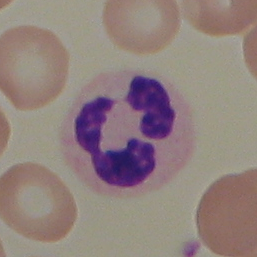

In [9]:
image = cv2.imread(str(data.iloc[0]['image']), -1)
print(f'image shape => {image.shape}')
if data.iloc[0]['label'] == 1:
  print(f'\nALL')
else:
  print(f'\nNon_ALL')  
cv2_imshow(image)

Now, we want to plot 5 examples for each class.

Non_ALL


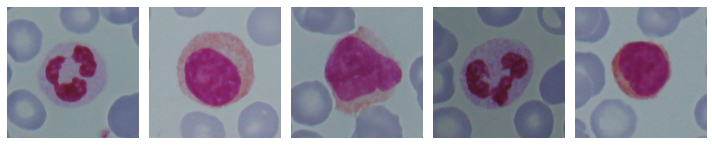

ALL


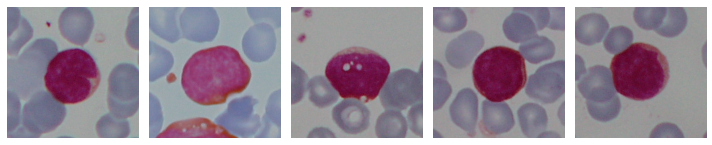

In [8]:
# Gather 5 Example images per label
labels = ['Non_ALL', 'ALL']
n_classes = 2
examples_per_sign = 5
total = 0
example = {}
for (img,label) in zip(data.image, data.label):
    example.setdefault(int(label), [])
    if len(example[int(label)]) < examples_per_sign:
        example[int(label)].append(str(img))
        total += 1
    if total == n_classes * examples_per_sign:
        break;

for label in sorted(example.keys()):
    fig = plt.figure(figsize=(10, 8))
    print(labels[label])
    for i in range(examples_per_sign):
        plt.subplot(1,examples_per_sign,i+1)
        img = cv2.imread(example[label][i], -1)
        plt.axis('off')
        plt.imshow(img)
    plt.tight_layout()    
    plt.show()

In [11]:
image = cv2.imread(str(data.iloc[0]['image']), -1)
n = len(data)
dim = image.shape[0]
images = np.zeros((n,dim,dim,3),dtype = np.float32)
labels = np.zeros((n,2),dtype = np.float32)

In [11]:
images.shape

(260, 257, 257, 3)

In [12]:
labels.shape

(260, 2)

اول میایم داده هامون رو به فرمت قابل قبول برای دادن به شبکه عصبی یا هر کلاسیفایر دیگه تبدیل می کنیم. به اینصورت که یک آرایه از نام پای برای ويژگی ها تشکیل می دهیم که لازمه اش اینه که سایز تمام تصاویر را به یک فرمت در آوریم و باید تصاویر رو هم نرمال بکنیم و در این ماتریس قرار دهیم. و بعدش باید برای برچسب هامون هم یک آرایه در نظر بگیریم.

تصاویر در ابعاد مختلفی در داده های ما وجود دارند.

In [16]:
image = cv2.imread(str(data.iloc[79]['image']), -1)

In [17]:
image.shape

(257, 193, 3)

In [20]:
def data_preprocessing(dataframe, dim):

  n = dataframe.shape[0]
  images = np.zeros((n,dim,dim,3),dtype = np.float32)
  labels = np.zeros((n,2),dtype = np.float32)
  for i in range(n):
    img = cv2.imread(str(dataframe.iloc[i]['image'])) 
    img = cv2.resize(img, (dim,dim))
    encoded_label = np_utils.to_categorical(data.iloc[i]['label'], num_classes=2)
    orig_img = img.astype(np.float32)/255.           
    images[i] = orig_img
    labels[i] = encoded_label

  return images, labels

In [21]:
images, labels = data_preprocessing(data, 100)
print(f'images shape : {images.shape}')
print(f'labels shape : {labels.shape}')

images shape : (260, 100, 100, 3)
labels shape : (260, 2)


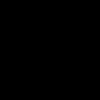

In [26]:
cv2_imshow(images[0])

In [27]:
images[0]

array([[[0.38431373, 0.43137255, 0.5568628 ],
        [0.4       , 0.43529412, 0.5568628 ],
        [0.4117647 , 0.44705883, 0.5686275 ],
        ...,
        [0.39215687, 0.42745098, 0.56078434],
        [0.39607844, 0.4392157 , 0.57254905],
        [0.4       , 0.43529412, 0.5686275 ]],

       [[0.39215687, 0.43137255, 0.56078434],
        [0.39215687, 0.44705883, 0.5686275 ],
        [0.41960785, 0.48235294, 0.5921569 ],
        ...,
        [0.4       , 0.43529412, 0.5686275 ],
        [0.3882353 , 0.4392157 , 0.56078434],
        [0.38431373, 0.44313726, 0.5568628 ]],

       [[0.38431373, 0.43529412, 0.5529412 ],
        [0.42745098, 0.5058824 , 0.6039216 ],
        [0.47843137, 0.56078434, 0.6431373 ],
        ...,
        [0.4       , 0.44313726, 0.56078434],
        [0.3764706 , 0.43137255, 0.54901963],
        [0.3647059 , 0.43529412, 0.54901963]],

       ...,

       [[0.40784314, 0.47843137, 0.5647059 ],
        [0.45882353, 0.5294118 , 0.58431375],
        [0.54509807, 0